# Comparison of ROMS subsetting with CO-OPs Subsetting Tool


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/asascience-open/xarray-subset-grid/blob/main/docs/examples/roms-compare.ipynb)

In [ ]:
# Install required libraries
# !pip install -q xarray_subset_grid@git+https://github.com/asascience-open/xarray-subset-grid.git
# !pip install -q s3fs cftime xarray cf-xarray fsspec dask h5netcdf

In [17]:
import fsspec
import numpy as np
import xarray as xr

import xarray_subset_grid.accessor  # noqa: F401

# open dataset as zarr object using fsspec reference file system and xarray
fs = fsspec.filesystem(
    "reference",
    fo="s3://nextgen-dmac-cloud-ingest/nos/wcofs/nos.wcofs.2ds.forecast.20240321.t03z.nc.zarr",
    remote_protocol="s3",
    remote_options={"anon": True},
    target_protocol="s3",
    target_options={"anon": True},
)
m = fs.get_mapper("")

ds = xr.open_dataset(
    m, engine="zarr", backend_kwargs=dict(consolidated=False), chunks={}
)
ds

<xarray.Dataset> Size: 2GB
Dimensions:        (tracer: 2, s_rho: 40, s_w: 41, ocean_time: 72,
                    eta_rho: 1016, xi_rho: 348, boundary: 4, eta_psi: 1015,
                    xi_psi: 347, eta_u: 1016, xi_u: 347, eta_v: 1015, xi_v: 348)
Coordinates:
    lat_psi        (eta_psi, xi_psi) float64 3MB dask.array<chunksize=(1015, 347), meta=np.ndarray>
    lat_rho        (eta_rho, xi_rho) float64 3MB dask.array<chunksize=(1016, 348), meta=np.ndarray>
    lat_u          (eta_u, xi_u) float64 3MB dask.array<chunksize=(1016, 347), meta=np.ndarray>
    lat_v          (eta_v, xi_v) float64 3MB dask.array<chunksize=(1015, 348), meta=np.ndarray>
    lon_psi        (eta_psi, xi_psi) float64 3MB dask.array<chunksize=(1015, 347), meta=np.ndarray>
    lon_rho        (eta_rho, xi_rho) float64 3MB dask.array<chunksize=(1016, 348), meta=np.ndarray>
    lon_u          (eta_u, xi_u) float64 3MB dask.array<chunksize=(1016, 347), meta=np.ndarray>
    lon_v          (eta_v, xi_v) float64 3MB dask.array<chunksize=(1015, 348), meta=np.ndarray>
  * ocean_time     (ocean_time) datetime64[ns] 576B 2024-03-21T04:00:00 ... 2...
  * s_rho          (s_rho) float64 320B -0.9875 -0.9625 ... -0.0375 -0.0125
  * s_w            (s_w) float64 328B -1.0 -0.975 -0.95 ... -0.05 -0.025 0.0
Dimensions without coordinates: tracer, eta_rho, xi_rho, boundary, eta_psi,
                                xi_psi, eta_u, xi_u, eta_v, xi_v
Data variables: (12/90)
    Akk_bak        float64 8B ...
    Akp_bak        float64 8B ...
    Akt_bak        (tracer) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
    Akv_bak        float64 8B ...
    Cs_r           (s_rho) float64 320B dask.array<chunksize=(40,), meta=np.ndarray>
    Cs_w           (s_w) float64 328B dask.array<chunksize=(41,), meta=np.ndarray>
    ...             ...
    theta_b        float64 8B ...
    theta_s        float64 8B ...
    u_sur          (ocean_time, eta_u, xi_u) float32 102MB dask.array<chunksize=(1, 1016, 347), meta=np.ndarray>
    v_sur          (ocean_time, eta_v, xi_v) float32 102MB dask.array<chunksize=(1, 1015, 348), meta=np.ndarray>
    xl             float64 8B ...
    zeta           (ocean_time, eta_rho, xi_rho) float32 102MB dask.array<chunksize=(1, 1016, 348), meta=np.ndarray>
Attributes: (12/36)
    CPP_options:       mode, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, AS...
    Conventions:       CF-1.4, SGRID-0.3
    NLM_LBC:           \nEDGE:  WEST   SOUTH  EAST   NORTH  \nzeta:  Cha    C...
    NLM_TADV:          \nADVECTION:   HORIZONTAL   VERTICAL     \ntemp:      ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    avg_file:          nos.wcofs.avg.nc
    ...                ...
    svn_url:           
    tide_file:         nos.wcofs.roms.tides.nc
    tiling:            008x060
    title:             wcofs forecast RUN in operational mode
    type:              ROMS/TOMS quicksave file
    var_info:          varinfo.yaml

In [18]:
f"Dataset size: {ds.nbytes * 1.0e-9} Gb"

'Dataset size: 1.8801388840000002 Gb'

### Example Polygon

Drawn with: https://geojson.io

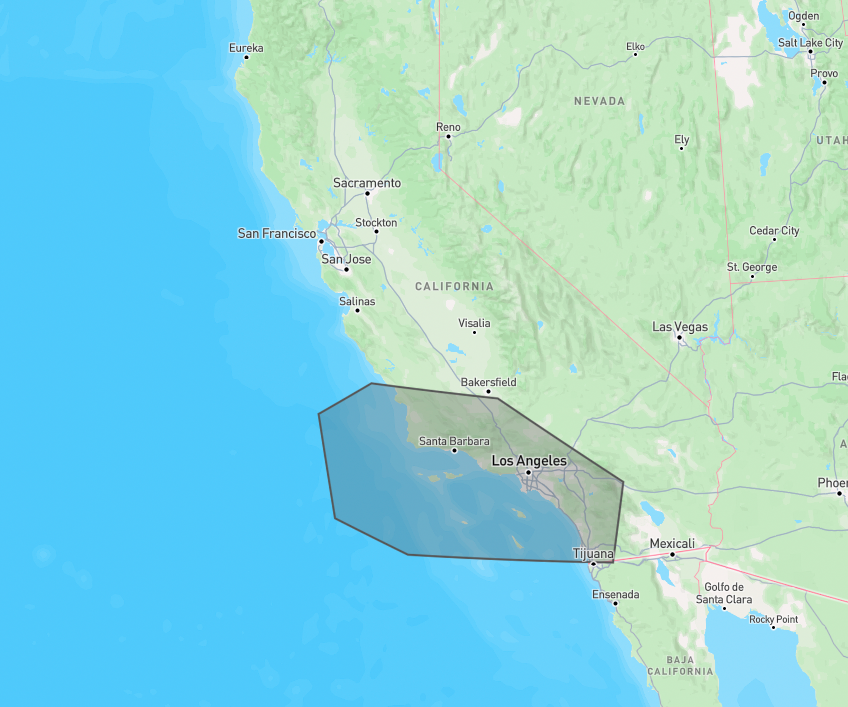

In [19]:
polygon = np.array(
    [
        [-122.38488806417945, 34.98888604471138],
        [-122.02425311530737, 33.300351211467074],
        [-120.60402628930146, 32.723214427630836],
        [-116.63789131284673, 32.54346959375448],
        [-116.39346090873218, 33.8541384965596],
        [-118.83845767505964, 35.257586401855164],
        [-121.34541503969862, 35.50073821008141],
        [-122.38488806417945, 34.98888604471138],
    ]
)

polygon

array([[-122.38488806,   34.98888604],
       [-122.02425312,   33.30035121],
       [-120.60402629,   32.72321443],
       [-116.63789131,   32.54346959],
       [-116.39346091,   33.8541385 ],
       [-118.83845768,   35.2575864 ],
       [-121.34541504,   35.50073821],
       [-122.38488806,   34.98888604]])

In [20]:
# get the subset of the grid that is within the polygon
ds_subset = ds.xsg.grid.subset_polygon(ds[['temp_sur', 'grid']], polygon)
ds_subset

<xarray.Dataset> Size: 5MB
Dimensions:     (ocean_time: 72, eta_rho: 125, xi_rho: 132)
Coordinates:
    lat_rho     (eta_rho, xi_rho) float64 132kB dask.array<chunksize=(125, 132), meta=np.ndarray>
    lon_rho     (eta_rho, xi_rho) float64 132kB dask.array<chunksize=(125, 132), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 576B 2024-03-21T04:00:00 ... 2024...
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    temp_sur    (ocean_time, eta_rho, xi_rho) float32 5MB dask.array<chunksize=(1, 125, 132), meta=np.ndarray>
    grid        int32 4B ...
Attributes: (12/36)
    CPP_options:       mode, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, AS...
    Conventions:       CF-1.4, SGRID-0.3
    NLM_LBC:           \nEDGE:  WEST   SOUTH  EAST   NORTH  \nzeta:  Cha    C...
    NLM_TADV:          \nADVECTION:   HORIZONTAL   VERTICAL     \ntemp:      ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    avg_file:          nos.wcofs.avg.nc
    ...                ...
    svn_url:           
    tide_file:         nos.wcofs.roms.tides.nc
    tiling:            008x060
    title:             wcofs forecast RUN in operational mode
    type:              ROMS/TOMS quicksave file
    var_info:          varinfo.yaml

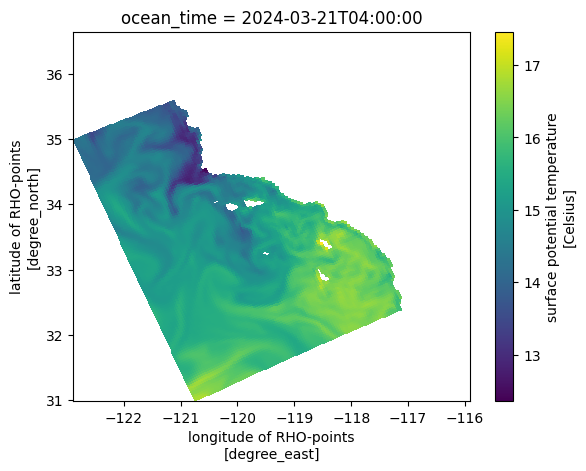

In [21]:
ds_subset.temp_sur.isel(ocean_time=0).plot(x="lon_rho", y="lat_rho")

In [9]:
f"Subset dataset size: {ds_subset.nbytes * 1.0e-6} Mb"

'Subset dataset size: 5.016579999999999 Mb'

## Compare against CO-OPs Subsetting Tool

Using the same vertices and only subsetting for temperature:

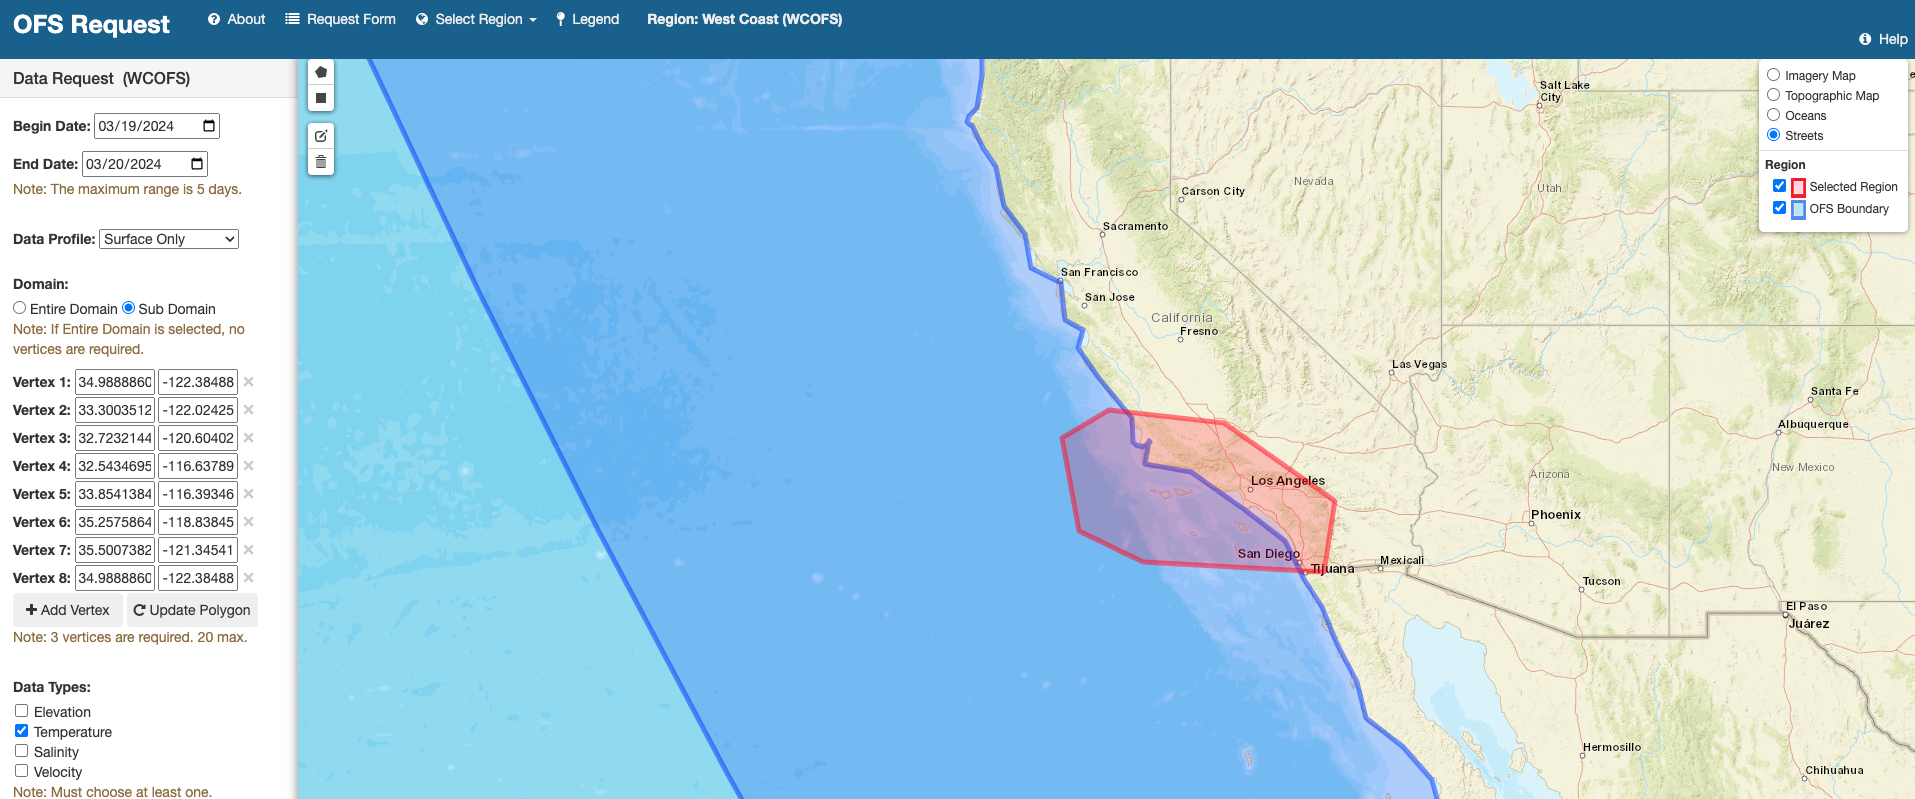

In [10]:
ds_subset_control = xr.open_dataset('./wcofs-subset-control.nc',
                                    chunks={},
                                    backend_kwargs={'decode_times': False})
ds_subset_control

<xarray.Dataset> Size: 7MB
Dimensions:          (nply: 8, two: 2, tracer: 2, boundary: 4, eta_rho: 120,
                      xi_rho: 103, eta_u: 120, xi_u: 102, eta_v: 119,
                      xi_v: 103, eta_psi: 119, xi_psi: 102, ocean_time: 49)
Coordinates:
    lon_rho          (eta_rho, xi_rho) float64 99kB dask.array<chunksize=(120, 103), meta=np.ndarray>
    lat_rho          (eta_rho, xi_rho) float64 99kB dask.array<chunksize=(120, 103), meta=np.ndarray>
    lon_u            (eta_u, xi_u) float64 98kB dask.array<chunksize=(120, 102), meta=np.ndarray>
    lat_u            (eta_u, xi_u) float64 98kB dask.array<chunksize=(120, 102), meta=np.ndarray>
    lon_v            (eta_v, xi_v) float64 98kB dask.array<chunksize=(119, 103), meta=np.ndarray>
    lat_v            (eta_v, xi_v) float64 98kB dask.array<chunksize=(119, 103), meta=np.ndarray>
    lon_psi          (eta_psi, xi_psi) float64 97kB dask.array<chunksize=(119, 102), meta=np.ndarray>
    lat_psi          (eta_psi, xi_psi) float64 97kB dask.array<chunksize=(119, 102), meta=np.ndarray>
  * ocean_time       (ocean_time) float64 392B 2.592e+08 2.592e+08 ... 2.594e+08
Dimensions without coordinates: nply, two, tracer, boundary, eta_rho, xi_rho,
                                eta_u, xi_u, eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/52)
    x                (nply) float64 64B dask.array<chunksize=(8,), meta=np.ndarray>
    y                (nply) float64 64B dask.array<chunksize=(8,), meta=np.ndarray>
    requested_times  (two) |S26 52B dask.array<chunksize=(2,), meta=np.ndarray>
    ntimes           int32 4B ...
    ndtfast          int32 4B ...
    dt               float64 8B ...
    ...               ...
    mask_u           (eta_u, xi_u) float64 98kB dask.array<chunksize=(120, 102), meta=np.ndarray>
    mask_v           (eta_v, xi_v) float64 98kB dask.array<chunksize=(119, 103), meta=np.ndarray>
    mask_psi         (eta_psi, xi_psi) float64 97kB dask.array<chunksize=(119, 102), meta=np.ndarray>
    nf_type          (ocean_time) int32 196B dask.array<chunksize=(49,), meta=np.ndarray>
    Times            (ocean_time) |S26 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    temp_sur         (ocean_time, eta_rho, xi_rho) float64 5MB dask.array<chunksize=(1, 120, 103), meta=np.ndarray>
Attributes: (12/38)
    note:              Output from CO-OPS subsetting/Aggregation tool
    user_email:        matthew.iannucci@tetratech.com
    file:              nos.wcofs.surface.nowcast.20240319.t03z_0022.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS quicksave file
    ...                ...
    compiler_command:  /opt/cray/pe/craype/2.7.10/bin/ftn
    compiler_flags:    -fp-model precise -ip -O3
    tiling:            008x060
    history:           ROMS/TOMS, Version 4.1, Tuesday - March 19, 2024 -  3:...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       mode, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, AS...

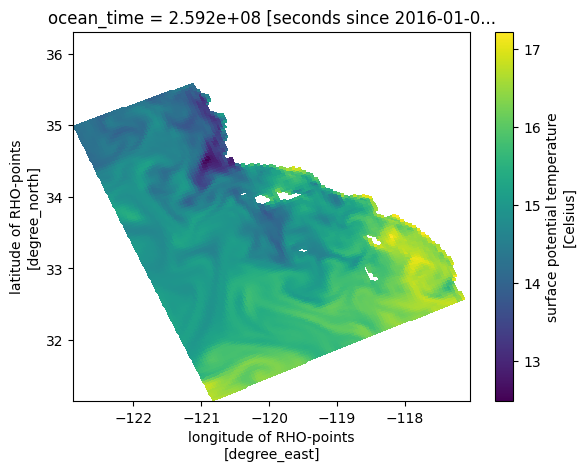

In [11]:
ds_subset_control.temp_sur.isel(ocean_time=0).plot(x="lon_rho", y="lat_rho")